In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os
import datetime

In [2]:
os.chdir('E:\Projects\Sales forecasting')

In [4]:
os.listdir()

['items.csv',
 'item_categories.csv',
 'sales_train.csv',
 'sample_submission.csv',
 'shops.csv',
 'test.csv']

In [32]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
sales = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
sub = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [36]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [37]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [40]:
sales['date'] = sales['date'].apply(lambda x:datetime.datetime.strptime(x,'%d.%m.%Y'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [49]:
sales[sales['date_block_num'] == 0].head(30)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


In [51]:
sales['Check month'] = pd.DatetimeIndex(sales['date']).month

In [53]:
sales['Check month'].value_counts()

1     303561
3     284057
12    274032
2     270251
8     248415
6     237428
7     234857
4     228289
10    227077
5     224836
9     219882
11    183164
Name: Check month, dtype: int64

In [54]:
sales['date_block_num'].value_counts()

11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
13     89830
24     88522
19     86614
22     86428
17     82408
21     79361
18     78760
16     78529
15     77906
20     73157
25     71808
26     69977
31     57029
27     56274
30     55549
29     54617
28     54548
33     53514
32     50588
Name: date_block_num, dtype: int64

In [41]:
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [55]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

In [59]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by = 'item_id', ascending = False)
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


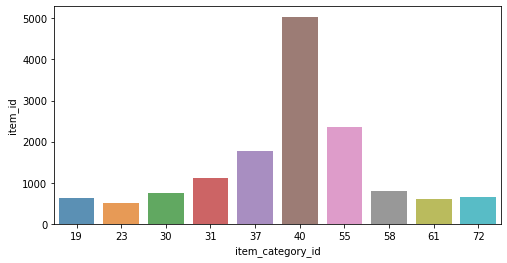

In [60]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.show()

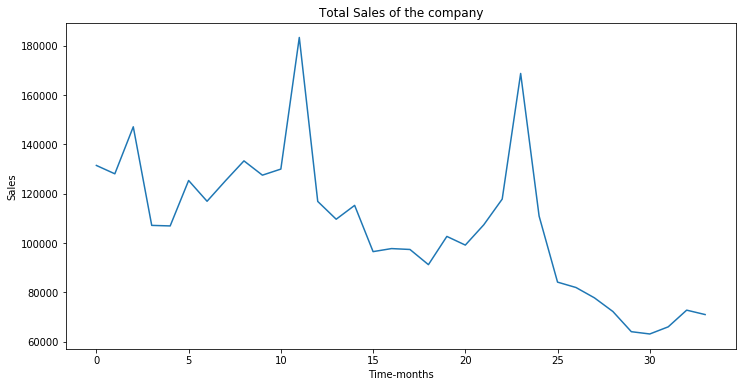

In [64]:
# Plotting total sales for company per month

ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
plt.figure(figsize = (12,6))
plt.title('Total Sales of the company')
plt.xlabel('Time-months')
plt.ylabel('Sales')
plt.plot(ts)

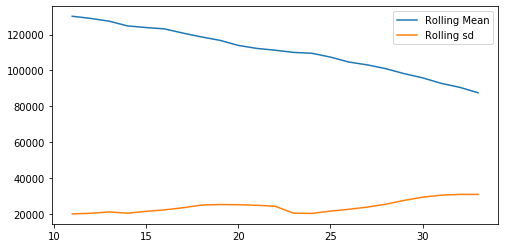

In [67]:
# Plotting rolling mean of the total sales data
plt.figure(figsize = (8,4))
plt.plot(ts.rolling(window = 12, center = False).mean(), label = 'Rolling Mean')
plt.plot(ts.rolling(window = 12, center = False).std(), label = 'Rolling sd')
plt.legend()

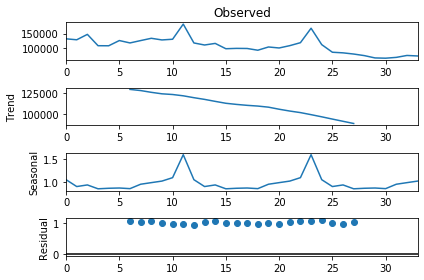

In [69]:
# Multiplicative model
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq = 12, model = 'multiplicative')
fig = res.plot()

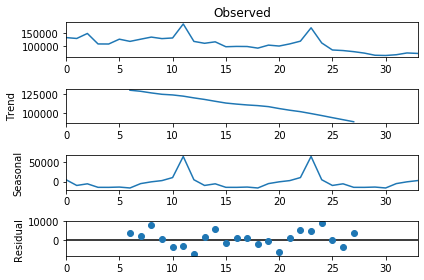

In [70]:
# Additive model
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq = 12, model = 'additive')
fig = res.plot()

In [82]:
# Stationarity check with Augmented Dicky Fuller test
def test_stationarity(timeseries):
    print("ADF test results: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [83]:
test_stationarity(ts)

ADF test results: 
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [88]:
# Function to remove trend and seasonality
def difference(dataset, interval = 1):
    diff = list()
    
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
        
    return pd.Series(diff)

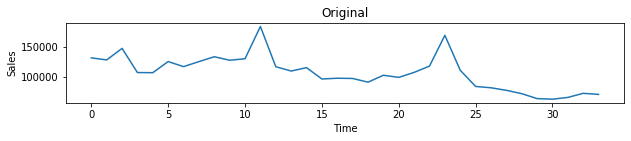

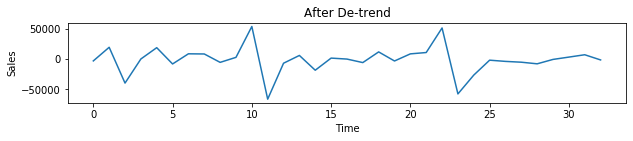

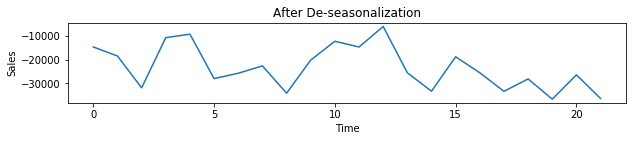

In [92]:
# Original time series 
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
plt.figure(figsize = (10,5))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

# After removing trend
plt.figure(figsize = (10,5))
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts,1)
plt.plot(new_ts)

# After removing seasonality
plt.figure(figsize = (10,5))
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts,12)
plt.plot(new_ts)

In [93]:
# Stationarity after de-seaosoning
test_stationarity(new_ts)

ADF test results: 
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
